In [58]:
from utils.general_utils import (print_metrics)
from core.find_prices_nonoverlap import *
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)
import warnings
warnings.filterwarnings(action='once')

/Users/derringi/.edm/envs/may2018/lib/python2.7/site-packages/ipykernel_launcher.py:2: ImportWarning: Not importing directory '/Users/derringi/git/ac-modeling/utils': missing __init__.py
  


ImportError: No module named utils.general_utils

In [56]:
df = pd.read_csv('single_family_home_values.csv')

print('Preparing Data: cleaning data')
not_useful_fields = ['id','city','state']#, 'address']
date_fields = ['lastSaleDate', 'priorSaleDate']
required_fields = ['address','latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt', 'lastSaleAmount',
                   'lastSaleDate','estimated_value', 'priorSaleDate','priorSaleAmount', 
                   'squareFootageOverLotSize','bathroomsPerRooms','hasPriorSale','bathroomsPerRooms']
zero_to_nan_fields = None
nan_to_zero_fields = ['latitude','longitude','priorSaleDate','priorSaleAmount']

df['squareFootageOverLotSize'] = df['squareFootage']/df['lotSize']
df['bathroomsPerRooms'] = df['bathrooms']/(df['rooms']+.01)
df['bathroomsPerRooms'] = df['rooms']/(df['squareFootage'])
df['hasPriorSale'] = ~pd.isnull(df['priorSaleDate'])
bad_idx = pd.isnull(df['yearBuilt'])
df.loc[bad_idx, 'yearBuilt'] = 0
print('Preparing Data: splitting test/train/validation')
df_train, df_test, df_validation = train_validate_test_split(df)

X_test = df_test[df_test.columns.drop('estimated_value')]
y_test = df_test['estimated_value']

X_train = df_train[df_train.columns.drop('estimated_value')]
y_train = df_train['estimated_value'] 

Preparing Data: cleaning data
Preparing Data: splitting test/train/validation


In [44]:
from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor 
)
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
print("Setting up pipeline")
features = ('latitude', 'longitude', 'zipcode',
            'bedrooms', 'bathrooms','rooms', 
            'squareFootage', 'lotSize', 
            'yearBuilt',
            'lastSaleAmount','lastSaleDateYear','lastSaleDateMonth','lastSaleDateDayOfWeek',
           'priorSaleAmount','priorSaleDateYear','priorSaleDateMonth','priorSaleDateDayOfWeek', 
            'squareFootageOverLotSize','bathroomsPerRooms','hasPriorSale','bathroomsPerRooms')


#: Note imputer will strip away column heads, it has to be after featurize
#reg_function = LGBMRegressor()
#reg_function = XGBRegressor()
# reg_function = RandomForestRegressor(n_jobs=3, criterion='mae') # about the same, slower by orders of magnitude
reg_function = RandomForestRegressor(n_jobs=3, criterion='mse')
# reg_function = LinearRegression() # Really Really bad
#reg_function = GradientBoostingRegressor()
#reg_function = ExtraTreesRegressor(n_estimators=2)
#reg_function = AdaBoostRegressor(); #Really bad


# prepare_data_pipeline = Pipeline([
#             ('prepare_data', PrepareData(required_fields=required_fields,
#                                          date_fields=date_fields,
#                                         zero_to_nan_fields=zero_to_nan_fields,
#                                         nan_to_zero_fields=nan_to_zero_fields)), 
#           ('featurize', featurize(features)),
#           ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
#             ])
prepare_data_pipeline = Pipeline([

        ('prepare_data', PrepareData(required_fields=required_fields,
                                         date_fields=date_fields,
                                        zero_to_nan_fields=zero_to_nan_fields,
                                        nan_to_zero_fields=nan_to_zero_fields)), 
            ('union', FeatureUnion(
                transformer_list=[
                    # Extracting street vector
                    ('subject',  StreetVectorizer()),
#                     ('imputerize_df', imputerize_df(features, df_out=True)),
                    # Featurizing all other values
                    ('featurize_df', featurize_df(features, df_out=False)),
                ]
             )),
                      ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
            ])

fit_data_pipeline = Pipeline([
#      ('dropout', Dropout(dropout_rate=0.99)),
          ('forest', reg_function),
            
            ])

Setting up pipeline
Featurize


In [45]:
# # from keras.layers import Dense, Dropout
# from keras.models import Model, Sequential
# from keras.wrappers.scikit_learn import KerasRegressor
# def create_model(optimizer='adagrad',
#                  kernel_initializer='glorot_uniform', 
#                  dropout=0.2):
#     model = Sequential()
#     model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer))
#     model.add(Dropout(dropout))
#     model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

#     model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=['accuracy'])

#     return model

# # wrap the model using the function you created
# clf = KerasRegressor(build_fn=create_model,verbose=0)
# scaler = StandardScaler()

# fit_data_pipeline = Pipeline([
# #     ('preprocess',scaler),
#           ('keras', clf)
#             ])

In [46]:
# y_train_sc = np.log(y_train+1)
# y_train_mu = np.mean(y_train_sc)
# y_train_std = np.std(y_train_sc)
# Y_train_sc = (y_train_sc-y_train_mu)/y_train_std

# y_test_sc = np.log(y_test+1)
# y_test_mu = np.mean(y_test_sc)
# y_test_std = np.std(y_test_sc)
# y_test_sc = (y_test_sc-y_train_mu)/y_test_std

y_train_sc = y_train
y_test_sc = y_test

x_train = prepare_data_pipeline.fit_transform(X = df_train, y = y_train_sc.values.reshape((-1,1)))

print("Fitting model on training data")
model = fit_data_pipeline.fit(X = x_train, y = y_train_sc.values.reshape((-1,1)))


Fitting model on training data


Evaluating model on training data
Sqrt mse: 63669.5172386
Mean absolute error: 23976.5710917
R2 score: 0.984372949036
Absolute mean relative error: 0.0318919523215


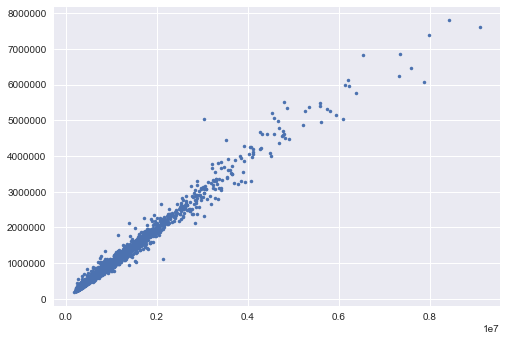

Evaluating model on testing data
Sqrt mse: 134429.088183
Mean absolute error: 57761.3378667
R2 score: 0.916779727005
Absolute mean relative error: 0.0775812972488


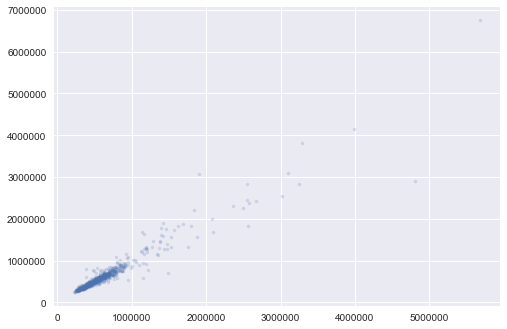

Successfully fit


In [53]:

print("Evaluating model on training data")
y_pred = model.predict(x_train)
# y_pred = model.named_steps['forest'].predict(x_train)
print_metrics(y_train_sc.values, y_pred)
plt.plot(y_train_sc.values, y_pred,'.')
y_max = (np.max((y_train_sc.values, y_pred.flatten())))
# plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

print("Evaluating model on testing data")
X_test = prepare_data_pipeline.transform(df_test)
y_test_pred = model.predict(X_test)
# y_test_pred = model.named_steps['forest'].predict(X_test)
print_metrics(y_test_sc.values, y_test_pred)
plt.plot(y_test_sc.values, y_test_pred.flatten(),'.', alpha=0.2)
y_max = np.max((y_test_sc, y_test_pred.flatten()))
# plt.plot((0,y_max), (0,y_max),color='black')

plt.show()
print("Successfully fit")

In [51]:
model.named_steps['forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [8]:
y_test_sc.values.shape
y_test_pred.shape

(750,)

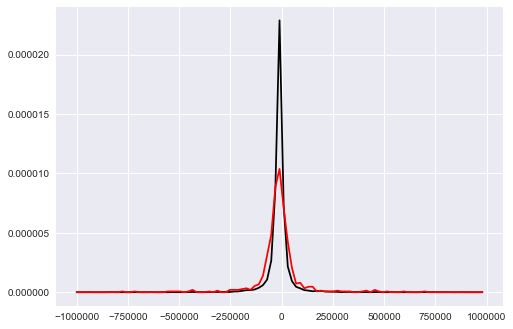

In [9]:
[c,b] = np.histogram(y_train_sc.values- y_pred.flatten(), bins = np.linspace(-1e6,1e6,100), normed=True)
plt.plot(b[:-1],c,'k')
[c,b] = np.histogram(y_test_sc.values- y_test_pred.flatten(), bins = np.linspace(-1e6,1e6,100), normed=True)
plt.plot(b[:-1],c,'r')
plt.show()

In [10]:
from sklearn.externals import joblib
filename = 'finalized_prepare_data_pipeline.sav'
joblib.dump(prepare_data_pipeline, filename)
filename = 'finalized_fit_data_pipeline.sav'
joblib.dump(fit_data_pipeline, filename)
  
# some time later...
 
# load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)

['finalized_fit_data_pipeline.sav']

In [11]:
sns.barplot(np.arange(len(fit_data_pipeline.steps[0][1].feature_importances_)),fit_data_pipeline.steps[0][1].feature_importances_)
plt.show()

AttributeError: 'Dropout' object has no attribute 'feature_importances_'

In [ ]:
len(features)

In [ ]:
asdf

In [ ]:
len(fit_data_pipeline.steps[0][1].feature_importances_)

In [ ]:
#: Work on using grid-searches
# params = {'forest__n_estimators':  (39,42)}
params = {'forest__n_estimators':  np.arange(5,45,5)}
# params = {'forest__n_estimators':  np.arange(35,45,5),
#           'forest__max_features':  ['auto','sqrt']}

from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p)
# transformer.transform(y)
grid = GridSearchCV(fit_data_pipeline, params)

grid.fit(X = x_train, y = y_train)

#: Definining a specified cross-validation technique
cv= StratifiedKFold(n_splits=2)

# Alternatively, can say can say cv=3 to say a 3-repeat cross-validator
grid_search = GridSearchCV(fit_data_pipeline, params, cv=5)
#gsearch = GridSearchCV(pipeline, params)
grid_search.fit(X = x_train, y = y_train)
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

In [ ]:
print(grid_search.cv_results_['mean_train_score'])
plt.plot(params['forest__n_estimators'], grid_search.cv_results_['mean_train_score'],'k')
plt.plot(params['forest__n_estimators'], grid_search.cv_results_['mean_test_score'],'r')
plt.show()

In [ ]:
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

In [ ]:
best_pipeline.feature_importances

In [ ]:
X = X_test
y = y_test
y_pred = best_pipeline.predict(X)
print_metrics(y, y_pred)
plt.plot(y, y_pred,'.',alpha=0.7)
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black',alpha=0.2)
plt.axes().set_aspect('equal')

plt.show()

In [ ]:
x_train.shape